Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize

from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/bgpelkie/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

## Load existing data

In [3]:
with open('/home/bgpelkie/Code/silica-np-synthesis/2024_10_17_RandomBaselineV4/constants_2024_10_17_randomV4.json', 'rt') as f:
    synth_constants = json.load(f) 

In [4]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [5]:
synth_data = pd.read_csv('synth_table_with_rmsedist_10_28_24.csv')
synth_data = synth_data[~synth_data['rmse_log_distance'].isna()]

In [6]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = synth_data['rmse_log_distance']

## data pre-processing

In [7]:
y_data[y_data ==50] = 5

In [8]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[0], [5]])).reshape(-1,1)

In [9]:
bounds_torch = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [10]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [11]:
x_data_norm = normalize(x_data_torch, bounds_torch)

## Set up BO things

In [12]:
bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)

BATCH_SIZE = 20  if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [13]:
def generate_initial_data(n=10):
    # generate training data
    train_x = torch.rand(10, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    best_observed_value = weighted_obj(train_x).max().item()
    return train_x, train_obj, best_observed_value


def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [14]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [15]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

t0 = time.monotonic()

# fit the models

fit_gpytorch_mll(mll_nei)

# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    options={"batch_limit": 5, "maxiter": 200},
)




In [16]:
candidates.shape

torch.Size([20, 3])

## Visualize new batch

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE()

In [19]:
x_data_norm.shape

torch.Size([99, 3])

In [20]:
all_x = torch.cat([x_data_norm, candidates])

In [21]:
x_tsne_og = tsne.fit_transform(all_x)

Text(0.5, 1.0, 'TSNE plot of initial data')

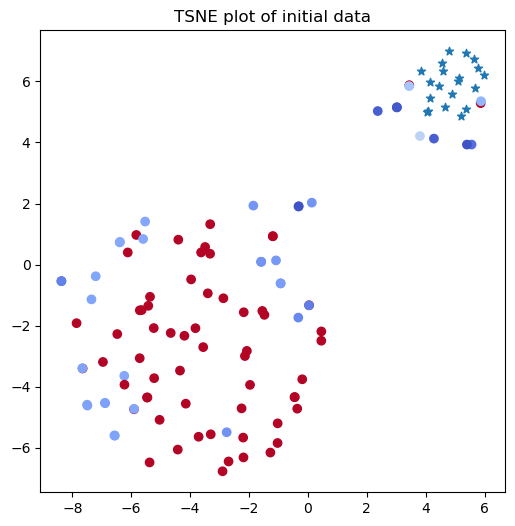

In [22]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")

## Prep new sample table for next experiment

In [23]:
x_fractions = unnormalize(candidates, bounds_torch)

In [24]:
x_fractions

tensor([[0.0302, 0.0164, 0.0256],
        [0.0121, 0.0081, 0.0071],
        [0.0114, 0.0062, 0.0067],
        [0.0114, 0.0064, 0.0086],
        [0.0310, 0.0059, 0.0267],
        [0.0115, 0.0157, 0.0260],
        [0.0307, 0.0166, 0.0267],
        [0.0152, 0.0059, 0.0221],
        [0.0172, 0.0154, 0.0078],
        [0.0130, 0.0055, 0.0057],
        [0.0211, 0.0062, 0.0174],
        [0.0293, 0.0143, 0.0202],
        [0.0172, 0.0073, 0.0194],
        [0.0293, 0.0124, 0.0162],
        [0.0201, 0.0094, 0.0207],
        [0.0222, 0.0055, 0.0057],
        [0.0225, 0.0086, 0.0164],
        [0.0121, 0.0161, 0.0206],
        [0.0247, 0.0079, 0.0224],
        [0.0238, 0.0139, 0.0224]])

In [25]:
target_volume = 1700
target_dilution = 0.048*1.5 # mol Si/L saxs sample
constants_fp = '/home/bgpelkie/Code/silica-np-synthesis/2024_11_04_OptimizationRound1/constants_2024_11_04.json'
samples_write_fp = '/home/bgpelkie/Code/silica-np-synthesis/Sample_table_2024_11_04_optimizationRound1.csv'


In [26]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

In [27]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [28]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction
0,f9b8246e-8b80-4955-9560-ada457bad27c,51.404155,27.952415,43.545530,1577.097900,0.531502,8.138741,0.010163
1,56faa977-e163-444a-9156-e2fa4f7fe338,20.531058,13.736371,12.098204,1653.634367,1.330736,3.250651,0.004097
2,da8a1479-69d0-45be-b579-65c7a1dfa21b,19.424944,10.564708,11.428266,1658.582082,1.406513,3.075522,0.003878
3,a20c37f0-5b38-4a7c-bee3-d0d3d116c9e0,19.390934,10.795518,14.617081,1655.196466,1.408979,3.070137,0.003870
4,c0c257a6-ec89-4274-8d2a-38b479f2eece,52.695785,9.986298,45.473300,1591.844618,0.518475,8.343243,0.010429
5,0ec4dd81-7487-4689-96b9-b0f646a2047d,19.506982,26.607262,44.223148,1609.662609,1.400597,3.088511,0.003870
6,ab43267e-6f46-4c9a-bc6a-ba6240fcb2fb,52.107864,28.135001,45.458031,1574.299103,0.524324,8.250158,0.010298
7,23709b8a-dfbe-4f00-b9a7-644344ee10e2,25.873608,9.969554,37.543594,1626.613244,1.055957,4.096529,0.005142
8,74579cb8-62f3-4d9e-8f66-6ca76a8ff53a,29.221116,26.235873,13.323223,1631.219788,0.934989,4.626535,0.005819
9,bfcf29cb-db74-40a1-9d27-911985c3f28f,22.154110,9.392500,9.732500,1658.720890,1.233244,3.507626,0.004423


In [29]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [30]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [31]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol
0,f9b8246e-8b80-4955-9560-ada457bad27c,51.404155,27.952415,43.545530,1577.097900,0.531502,8.138741,0.010163,796.0,904.0
1,56faa977-e163-444a-9156-e2fa4f7fe338,20.531058,13.736371,12.098204,1653.634367,1.330736,3.250651,0.004097,0.0,1700.0
2,da8a1479-69d0-45be-b579-65c7a1dfa21b,19.424944,10.564708,11.428266,1658.582082,1.406513,3.075522,0.003878,0.0,1700.0
3,a20c37f0-5b38-4a7c-bee3-d0d3d116c9e0,19.390934,10.795518,14.617081,1655.196466,1.408979,3.070137,0.003870,0.0,1700.0
4,c0c257a6-ec89-4274-8d2a-38b479f2eece,52.695785,9.986298,45.473300,1591.844618,0.518475,8.343243,0.010429,819.0,881.0
5,0ec4dd81-7487-4689-96b9-b0f646a2047d,19.506982,26.607262,44.223148,1609.662609,1.400597,3.088511,0.003870,0.0,1700.0
6,ab43267e-6f46-4c9a-bc6a-ba6240fcb2fb,52.107864,28.135001,45.458031,1574.299103,0.524324,8.250158,0.010298,809.0,891.0
7,23709b8a-dfbe-4f00-b9a7-644344ee10e2,25.873608,9.969554,37.543594,1626.613244,1.055957,4.096529,0.005142,0.0,1700.0
8,74579cb8-62f3-4d9e-8f66-6ca76a8ff53a,29.221116,26.235873,13.323223,1631.219788,0.934989,4.626535,0.005819,111.0,1589.0
9,bfcf29cb-db74-40a1-9d27-911985c3f28f,22.154110,9.392500,9.732500,1658.720890,1.233244,3.507626,0.004423,0.0,1700.0


In [32]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [33]:
synth_table['well'] = wells[:len(synth_table)]


In [34]:
synth_table['dilute_well'] = wells[len(synth_table):2*len(synth_table)]

In [35]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,f9b8246e-8b80-4955-9560-ada457bad27c,51.404155,27.952415,43.545530,1577.097900,0.531502,8.138741,0.010163,796.0,904.0,A1,C7
1,56faa977-e163-444a-9156-e2fa4f7fe338,20.531058,13.736371,12.098204,1653.634367,1.330736,3.250651,0.004097,0.0,1700.0,A2,C8
2,da8a1479-69d0-45be-b579-65c7a1dfa21b,19.424944,10.564708,11.428266,1658.582082,1.406513,3.075522,0.003878,0.0,1700.0,A3,D1
3,a20c37f0-5b38-4a7c-bee3-d0d3d116c9e0,19.390934,10.795518,14.617081,1655.196466,1.408979,3.070137,0.003870,0.0,1700.0,A4,D2
4,c0c257a6-ec89-4274-8d2a-38b479f2eece,52.695785,9.986298,45.473300,1591.844618,0.518475,8.343243,0.010429,819.0,881.0,A5,D3
5,0ec4dd81-7487-4689-96b9-b0f646a2047d,19.506982,26.607262,44.223148,1609.662609,1.400597,3.088511,0.003870,0.0,1700.0,A6,D4
6,ab43267e-6f46-4c9a-bc6a-ba6240fcb2fb,52.107864,28.135001,45.458031,1574.299103,0.524324,8.250158,0.010298,809.0,891.0,A7,D5
7,23709b8a-dfbe-4f00-b9a7-644344ee10e2,25.873608,9.969554,37.543594,1626.613244,1.055957,4.096529,0.005142,0.0,1700.0,A8,D6
8,74579cb8-62f3-4d9e-8f66-6ca76a8ff53a,29.221116,26.235873,13.323223,1631.219788,0.934989,4.626535,0.005819,111.0,1589.0,B1,D7
9,bfcf29cb-db74-40a1-9d27-911985c3f28f,22.154110,9.392500,9.732500,1658.720890,1.233244,3.507626,0.004423,0.0,1700.0,B3,D8


In [36]:
synth_table.to_csv('SampleTable_2024_11_04_OptimizationRound1.csv')